In [1]:
# Data manipulation
import numpy as np
import pandas as pd
from math import *
import seaborn as sns

# Visualization.
import matplotlib.pyplot as plt

# Saving models
from datetime import datetime
import joblib

# Display all columns
pd.set_option('display.max_columns', 150,
             'display.max_rows', 150)

# ML
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, RepeatedKFold, train_test_split, cross_validate, cross_val_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, median_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet

In [2]:
def distance(s_lat, s_lng, e_lat, e_lng):

    # approximate radius of earth in km
    R = 6373.0

    s_lat = s_lat*np.pi/180.0                      
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  

    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

    return 2 * R * np.arcsin(np.sqrt(d))

### Read the data
   * Dataset order_products

In [3]:
order_products = pd.read_csv("/Users/aurelianosancho/Documents/GitHub/teste_cornershop/order_products.csv")

In [4]:
order_products.isnull().sum()

order_id      0
product_id    0
quantity      0
buy_unit      0
dtype: int64

In [5]:
order_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198500 entries, 0 to 198499
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   order_id    198500 non-null  object 
 1   product_id  198500 non-null  object 
 2   quantity    198500 non-null  float64
 3   buy_unit    198500 non-null  object 
dtypes: float64(1), object(3)
memory usage: 6.1+ MB


In [6]:
order_products.loc[order_products['buy_unit'] == 'UN', 'quantity_UN'] = order_products['quantity']
order_products.loc[order_products['quantity_UN'].isnull(), 'quantity_UN'] = 0

order_products.loc[order_products['buy_unit'] == 'KG', 'quantity_KG'] = order_products['quantity']
order_products.loc[order_products['quantity_KG'].isnull(), 'quantity_KG'] = 0

In [7]:
order_products.head(3)

,order_id,product_id,quantity,buy_unit,quantity_UN,quantity_KG
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN,1.0,0.0
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG,0.0,1.0
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN,1.0,0.0


In [8]:
order_products = order_products.groupby('order_id').aggregate(
                            {'quantity_UN': 'sum',
                             'quantity_KG': 'sum'
                            }).reset_index()

In [9]:
order_products.loc[order_products['quantity_UN'] >= order_products['quantity_KG'], 'is_more_UN'] = 1
order_products.loc[order_products['is_more_UN'].isnull(), 'is_more_UN'] = 0

In [10]:
order_products['UN_plus_KG'] = order_products['quantity_UN'] + order_products['quantity_KG']
order_products['UN_mult_KG'] = order_products['quantity_UN']*order_products['quantity_KG']

In [11]:
order_products.head()

,order_id,quantity_UN,quantity_KG,is_more_UN,UN_plus_KG,UN_mult_KG
0,0004a3841c1eeb6c6e77585a941c21e0,8.0,0.000,1.0,8.000,0.000
1,0005a6ecbbde1e8d273f5577bcff2c9c,2.0,0.000,1.0,2.000,0.000
2,0007baeb6700fc203be2d1f1e11222d7,39.0,0.000,1.0,39.000,0.000
3,0012195a6a8ca9ec308a3010eeea8ebc,13.0,0.000,1.0,13.000,0.000
4,0013011fa72b498b9feb84f4e7104980,63.0,1.636,1.0,64.636,103.068


In [12]:
order_products.isnull().sum()

order_id       0
quantity_UN    0
quantity_KG    0
is_more_UN     0
UN_plus_KG     0
UN_mult_KG     0
dtype: int64

* Dataset orders

In [13]:
orders = pd.read_csv("/Users/aurelianosancho/Documents/GitHub/teste_cornershop/orders.csv")

In [14]:
orders.isnull().sum()

order_id              0
lat                   0
lng                   0
promised_time         0
on_demand             0
shopper_id            0
store_branch_id       0
total_minutes      2000
dtype: int64

In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         10000 non-null  object 
 1   lat              10000 non-null  float64
 2   lng              10000 non-null  float64
 3   promised_time    10000 non-null  object 
 4   on_demand        10000 non-null  bool   
 5   shopper_id       10000 non-null  object 
 6   store_branch_id  10000 non-null  object 
 7   total_minutes    8000 non-null   float64
dtypes: bool(1), float64(3), object(4)
memory usage: 556.8+ KB


In [16]:
orders.head(3)

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN


#### Join the datasets

In [17]:
full = pd.merge(orders, order_products, how='inner', on='order_id')

In [18]:
full.isnull().sum()

order_id              0
lat                   0
lng                   0
promised_time         0
on_demand             0
shopper_id            0
store_branch_id       0
total_minutes      1995
quantity_UN           0
quantity_KG           0
is_more_UN            0
UN_plus_KG            0
UN_mult_KG            0
dtype: int64

   * Dataset shoppers

In [19]:
shoppers = pd.read_csv("/Users/aurelianosancho/Documents/GitHub/teste_cornershop/shoppers.csv")

In [20]:
shoppers.isnull().sum()

shopper_id         0
seniority          0
found_rate       101
picking_speed      0
accepted_rate     27
rating            84
dtype: int64

In [21]:
shoppers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   shopper_id     2864 non-null   object 
 1   seniority      2864 non-null   object 
 2   found_rate     2763 non-null   float64
 3   picking_speed  2864 non-null   float64
 4   accepted_rate  2837 non-null   float64
 5   rating         2780 non-null   float64
dtypes: float64(4), object(2)
memory usage: 134.4+ KB


In [22]:
shoppers.head(3)

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88


In [23]:
found_rate = shoppers[shoppers.found_rate.isnull()]

In [24]:
found_rate.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
41,3037b3b45878cc009165ab18046545e2,bb29b8d0d196b5db5a5350e5e3ae2b1f,NaN,2.19,1.0,NaN
48,767014694eecb27868fcab3e18bbeb2d,bb29b8d0d196b5db5a5350e5e3ae2b1f,NaN,2.19,0.8,NaN
50,43ad600bfd3b16b220d90a1f6e25681e,bb29b8d0d196b5db5a5350e5e3ae2b1f,NaN,2.19,NaN,NaN
83,32cee31f8f74a1573a8e07fc90d456b9,50e13ee63f086c2fe84229348bc91b5b,NaN,2.19,0.8,NaN


In [25]:
found_rate.picking_speed.unique()

array([2.41, 2.19, 2.33])

In [26]:
found_rate2 = shoppers[(shoppers.picking_speed == 2.41) | (shoppers.picking_speed == 2.19) | (shoppers.picking_speed == 2.33)]

In [27]:
found_rate2['found_rate'].mode().iat[0]

0.7754

In [28]:
shoppers.loc[shoppers['found_rate'].isnull(), 'found_rate'] = 0.7754

In [29]:
shoppers.isnull().sum()

shopper_id        0
seniority         0
found_rate        0
picking_speed     0
accepted_rate    27
rating           84
dtype: int64

In [30]:
shoppers.loc[shoppers['accepted_rate'].isnull(), 'accepted_rate'] = shoppers['accepted_rate'].mode().iat[0]
shoppers.loc[shoppers['rating'].isnull(), 'rating'] = shoppers['rating'].mode().iat[0]

In [31]:
shoppers.isnull().sum()

shopper_id       0
seniority        0
found_rate       0
picking_speed    0
accepted_rate    0
rating           0
dtype: int64

In [32]:
full.isnull().sum()

order_id              0
lat                   0
lng                   0
promised_time         0
on_demand             0
shopper_id            0
store_branch_id       0
total_minutes      1995
quantity_UN           0
quantity_KG           0
is_more_UN            0
UN_plus_KG            0
UN_mult_KG            0
dtype: int64

In [33]:
full = pd.merge(full, shoppers, how='left', on='shopper_id')

In [34]:
full.isnull().sum()

order_id              0
lat                   0
lng                   0
promised_time         0
on_demand             0
shopper_id            0
store_branch_id       0
total_minutes      1995
quantity_UN           0
quantity_KG           0
is_more_UN            0
UN_plus_KG            0
UN_mult_KG            0
seniority             0
found_rate            0
picking_speed         0
accepted_rate         0
rating                0
dtype: int64

   * Dataset storebranch

In [35]:
storebranch = pd.read_csv("/Users/aurelianosancho/Documents/GitHub/teste_cornershop/storebranch.csv")

In [36]:
storebranch.isnull().sum()

store_branch_id    0
store_id           0
lat                0
lng                0
dtype: int64

In [37]:
storebranch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store_branch_id  476 non-null    object 
 1   store_id         476 non-null    object 
 2   lat              476 non-null    float64
 3   lng              476 non-null    float64
dtypes: float64(2), object(2)
memory usage: 15.0+ KB


In [38]:
storebranch.head(3)

,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224


In [39]:
full = pd.merge(full, storebranch, how='left', on='store_branch_id')

In [40]:
full.isnull().sum()

order_id              0
lat_x                 0
lng_x                 0
promised_time         0
on_demand             0
shopper_id            0
store_branch_id       0
total_minutes      1995
quantity_UN           0
quantity_KG           0
is_more_UN            0
UN_plus_KG            0
UN_mult_KG            0
seniority             0
found_rate            0
picking_speed         0
accepted_rate         0
rating                0
store_id              0
lat_y                 0
lng_y                 0
dtype: int64

In [41]:
full['promised_time'] = pd.to_datetime(full['promised_time'])

In [42]:
full['Hour'] = full['promised_time'].apply(lambda time: time.hour)
full['Month'] = full['promised_time'].apply(lambda time: time.month)
full['Day_of_Week'] = full['promised_time'].apply(lambda time: time.dayofweek)
full['Year'] = full['promised_time'].apply(lambda t: t.year)
full['Date'] = full['promised_time'].apply(lambda t: t.day)

In [43]:
full.head(3)

,order_id,lat_x,lng_x,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,quantity_UN,quantity_KG,is_more_UN,UN_plus_KG,UN_mult_KG,seniority,found_rate,picking_speed,accepted_rate,rating,store_id,lat_y,lng_y,Hour,Month,Day_of_Week,Year,Date
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,16.0,2.756,1.0,18.756,44.096,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.485280,-70.579250,20,10,4,2019,18
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,11.0,0.000,1.0,11.000,0.000,41dc7c9e385c4d2b6c1f7836973951bf,0.7610,2.54,0.92,4.96,c4ca4238a0b923820dcc509a6f75849b,-33.441246,-70.535450,1,10,5,2019,19
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,18.0,0.000,1.0,18.000,0.000,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,14,10,5,2019,19


In [44]:
full.loc[(full['Hour'] >= 6) & (full['Hour'] < 12), 'period'] = 'morning'
full.loc[(full['Hour'] >= 12) & (full['Hour'] < 18), 'period'] = 'afternoon'
full.loc[(full['Hour'] >= 18) & (full['Hour'] <= 24), 'period'] = 'night'
full.loc[(full['Hour'] < 6), 'period'] = 'dawn'

In [45]:
full['distance'] = distance(full.lat_x, full.lng_x, full.lat_y, full.lng_y)

In [46]:
full.isnull().sum()

order_id              0
lat_x                 0
lng_x                 0
promised_time         0
on_demand             0
shopper_id            0
store_branch_id       0
total_minutes      1995
quantity_UN           0
quantity_KG           0
is_more_UN            0
UN_plus_KG            0
UN_mult_KG            0
seniority             0
found_rate            0
picking_speed         0
accepted_rate         0
rating                0
store_id              0
lat_y                 0
lng_y                 0
Hour                  0
Month                 0
Day_of_Week           0
Year                  0
Date                  0
period                0
distance              0
dtype: int64

In [47]:
full[['found_rate', 'picking_speed',
       'accepted_rate', 'rating']]

,found_rate,picking_speed,accepted_rate,rating
0,0.9024,1.30,0.920000,4.76
1,0.7610,2.54,0.920000,4.96
2,0.8313,2.57,0.760000,4.92
3,0.8776,2.80,0.960000,4.76
4,0.7838,2.40,0.960000,4.96
...,...,...,...,...
9973,0.8658,1.30,0.960000,4.92
9974,0.8970,1.41,1.000000,4.68
9975,0.8424,1.40,1.000000,4.76
9976,0.8529,1.98,0.933333,4.86


In [48]:
var_cat = ['on_demand', 'seniority', 'Hour', 'Day_of_Week', 'period']
var_num = ['quantity_UN', 'quantity_KG', 'UN_plus_KG', 'UN_mult_KG',
           'distance', 
           'found_rate', 'picking_speed',
       'accepted_rate', 'rating']

In [49]:
full = pd.get_dummies(full, columns = var_cat)

In [50]:
cdrop = ['order_id', 'shopper_id', 'store_branch_id', 'store_id',
         'Month', 'Year', 'Date']

In [51]:
full = full.drop(cdrop, axis = 1)

In [52]:
var = ['total_minutes', 'quantity_UN',
       'quantity_KG', 'is_more_UN', 'UN_plus_KG', 'UN_mult_KG', 'found_rate',
       'picking_speed', 'accepted_rate', 'rating',
       'distance', 
       'on_demand_False', 'on_demand_True',
       'seniority_41dc7c9e385c4d2b6c1f7836973951bf',
       'seniority_50e13ee63f086c2fe84229348bc91b5b',
       'seniority_6c90661e6d2c7579f5ce337c3391dbb9',
       'seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f', 'Hour_0', 'Hour_1',
       'Hour_2', 'Hour_3', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
       'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23', 'Day_of_Week_4', 'Day_of_Week_5',
       'Day_of_Week_6', 'period_afternoon', 'period_dawn', 'period_morning',
       'period_night']

full = full[var]

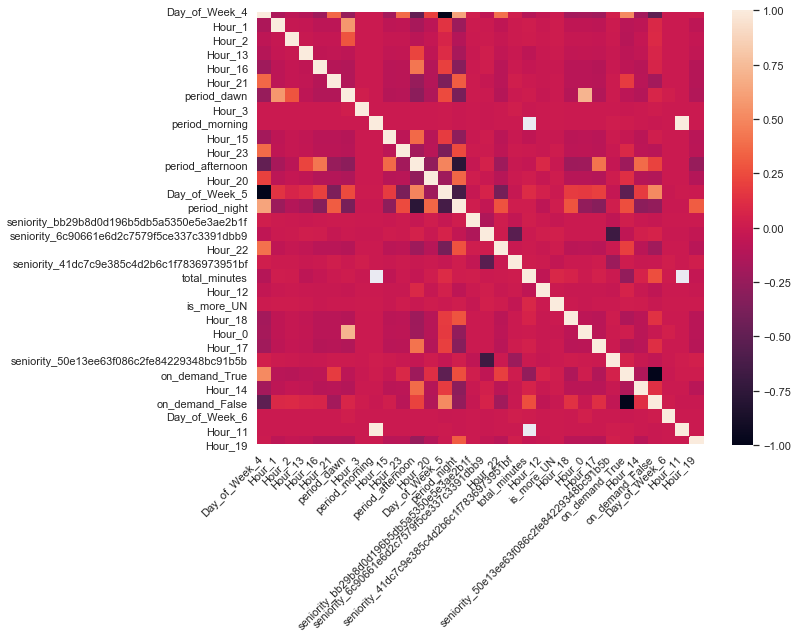

In [53]:
sns.set(rc={'figure.figsize':(10,8)})
var_corr = list(set(full.columns) - set(var_num))
corr = full[var_corr].corr()

ax = sns.heatmap(
    corr, 
    #vmin=-1, vmax=1, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    square=True#, annot= True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

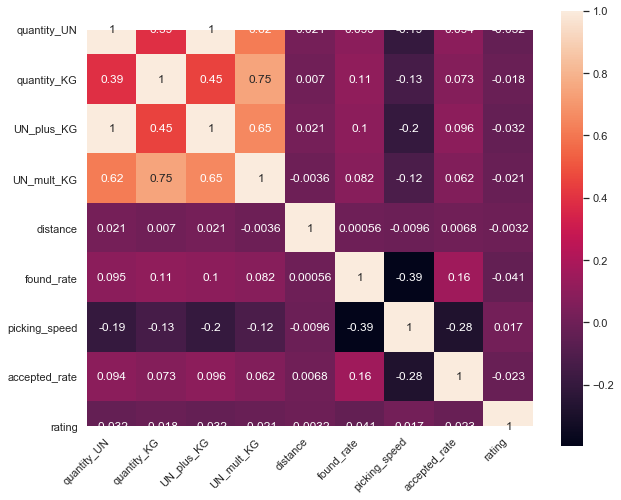

In [54]:
sns.set(rc={'figure.figsize':(10,8)})
corr = full[var_num].corr()

ax = sns.heatmap(
    corr, 
    #vmin=-1, vmax=1, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot= True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### out of sample

In [55]:
ofs = full[full.total_minutes.isnull()]

In [56]:
ofs.head(3)

,total_minutes,quantity_UN,quantity_KG,is_more_UN,UN_plus_KG,UN_mult_KG,found_rate,picking_speed,accepted_rate,rating,distance,on_demand_False,on_demand_True,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f,Hour_0,Hour_1,Hour_2,Hour_3,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6,period_afternoon,period_dawn,period_morning,period_night
2,NaN,18.0,0.000,1.0,18.000,0.000,0.8313,2.57,0.76,4.92,2.358128,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
5,NaN,15.0,0.000,1.0,15.000,0.000,0.8946,1.82,1.00,4.84,4.190793,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
9,NaN,94.0,2.852,1.0,96.852,268.088,0.9363,1.67,1.00,4.84,2.512359,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


In [57]:
ofs.isnull().sum()

total_minutes                                 1995
quantity_UN                                      0
quantity_KG                                      0
is_more_UN                                       0
UN_plus_KG                                       0
UN_mult_KG                                       0
found_rate                                       0
picking_speed                                    0
accepted_rate                                    0
rating                                           0
distance                                         0
on_demand_False                                  0
on_demand_True                                   0
seniority_41dc7c9e385c4d2b6c1f7836973951bf       0
seniority_50e13ee63f086c2fe84229348bc91b5b       0
seniority_6c90661e6d2c7579f5ce337c3391dbb9       0
seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f       0
Hour_0                                           0
Hour_1                                           0
Hour_2                         

### modeling data

In [58]:
modeling = full[~full.total_minutes.isnull()]

In [59]:
modeling.head(3)

,total_minutes,quantity_UN,quantity_KG,is_more_UN,UN_plus_KG,UN_mult_KG,found_rate,picking_speed,accepted_rate,rating,distance,on_demand_False,on_demand_True,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f,Hour_0,Hour_1,Hour_2,Hour_3,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6,period_afternoon,period_dawn,period_morning,period_night
0,67.684264,16.0,2.756,1.0,18.756,44.096,0.9024,1.30,0.92,4.76,1.823597,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,57.060632,11.0,0.000,1.0,11.000,0.000,0.7610,2.54,0.92,4.96,1.935026,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,52.067742,1.0,0.000,1.0,1.000,0.000,0.8776,2.80,0.96,4.76,3.820244,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


In [60]:
modeling.isnull().sum()

total_minutes                                 0
quantity_UN                                   0
quantity_KG                                   0
is_more_UN                                    0
UN_plus_KG                                    0
UN_mult_KG                                    0
found_rate                                    0
picking_speed                                 0
accepted_rate                                 0
rating                                        0
distance                                      0
on_demand_False                               0
on_demand_True                                0
seniority_41dc7c9e385c4d2b6c1f7836973951bf    0
seniority_50e13ee63f086c2fe84229348bc91b5b    0
seniority_6c90661e6d2c7579f5ce337c3391dbb9    0
seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f    0
Hour_0                                        0
Hour_1                                        0
Hour_2                                        0
Hour_3                                  

In [61]:
# Getting the data:
X = modeling.drop(['total_minutes'], axis = 1)

y = modeling['total_minutes']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 451, test_size= .25)

In [63]:
StdSca = StandardScaler() ## or standerscaler 
X_train[var_num] = pd.DataFrame(StdSca.fit_transform(X_train[var_num]), columns = var_num, index = X_train.index)
X_test[var_num] = pd.DataFrame(StdSca.transform(X_test[var_num]), columns = var_num, index = X_test.index)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [64]:
ofs[var_num] = StdSca.transform(ofs[var_num])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


## Model

In [65]:
# LinearRegression()

In [66]:
CV = cross_validate(estimator = LinearRegression(), 
                    cv = 5, 
                    #scoring = "r2", 
                    scoring = ["r2", "explained_variance", "neg_root_mean_squared_error", "neg_median_absolute_error"], 
                    X = X_train,
                    y = y_train)

cv_df = pd.DataFrame(CV)
cv_df

,fit_time,score_time,test_r2,test_explained_variance,test_neg_root_mean_squared_error,test_neg_median_absolute_error
0,0.323361,0.009942,0.409319,0.409538,-26.576634,-16.835801
1,0.014964,0.006506,0.349698,0.350754,-28.060047,-15.921310
2,0.014346,0.006056,0.382454,0.384593,-27.191109,-16.369156
3,0.014627,0.008295,0.435129,0.435722,-25.852322,-16.383563
4,0.013272,0.007218,0.479246,0.480840,-24.808525,-16.225689


In [67]:
CV = cross_validate(estimator = ElasticNet(alpha=1.0, l1_ratio=0.5), 
                    cv = 5, 
                    #scoring = "r2", 
                    scoring = ["r2", "explained_variance", "neg_root_mean_squared_error", "neg_median_absolute_error"], 
                    X = X_train,
                    y = y_train)

cv_df = pd.DataFrame(CV)
cv_df

,fit_time,score_time,test_r2,test_explained_variance,test_neg_root_mean_squared_error,test_neg_median_absolute_error
0,0.059123,0.009251,0.353288,0.353289,-27.808592,-18.009004
1,0.017314,0.006329,0.303915,0.304617,-29.031003,-17.638097
2,0.012451,0.006479,0.328733,0.330710,-28.349126,-18.229622
3,0.012626,0.006244,0.372282,0.372858,-27.252551,-17.840343
4,0.012583,0.006268,0.413247,0.415645,-26.333737,-18.519413


In [68]:
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1, 0.01)

In [69]:
md = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

In [ ]:
search = GridSearchCV(md, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

In [ ]:
model = ElasticNet().fit(X = X_train, y = y_train)